In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00


In [2]:

import os
import pandas as pd
import numpy as np
import pickle
from google.colab import drive
import torch
from torch_geometric.data import Data, HeteroData
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.nn import Node2Vec, to_hetero
import torch_geometric.transforms as T
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!cd /content/drive/Shareddrives/cs224w
dir_path = "/content/drive/Shareddrives/cs224w/"

In [5]:
ftrs_path = dir_path + "features_unravelled.parquet"
embs_path = dir_path + "emotion_embs.parquet"
embs_cat_path = dir_path + "emotion_cat_embs.parquet"

df_ftrs = pd.read_parquet(ftrs_path)
df_em = pd.read_parquet(embs_path)
df_em_cat = pd.read_parquet(embs_cat_path)

### DataFrame Shape Adjustment

In [6]:
def unravel_df(df):
    # unravel features that are in a list or dict form
    dict_cols = [col for col in df if df[col].apply(lambda x: isinstance(x, dict)).all()]
    for col in dict_cols:
        x_normalized = pd.json_normalize(df[col])
        df = pd.concat([df.drop(columns=[col]), x_normalized], axis=1)
    return df

def explode_df(df):
    # split up columns so that each feature is an int or float
    array_cols = [col for col in df.columns if isinstance(df[col].iloc[0], (list, np.ndarray))]
    expanded_dfs = []
    for col in array_cols:
        arr_length = len(df[col].iloc[0])
        expanded = pd.DataFrame(df[col].tolist())
        expanded_dfs.append(expanded)

    non_array_df = df.drop(columns=array_cols)
    final_df = pd.concat([non_array_df] + expanded_dfs, axis=1)
    return final_df


In [7]:
# adjust features to be the proper format
df_ftrs = unravel_df(df_ftrs)
df_ftrs['post_count'] = df_ftrs['text_cleaned'].apply(lambda x: len(x))
ftrs_list = ['user_id', 'sum_emb', 'valence', 'arousal', 'dominance', 'concreteness', 'IQR', 'Max', 'Mean', 'Median', 'Min', 'ACC', 'Len', 'Unique', 'post_count']
df_graph_ftrs = df_ftrs[ftrs_list]

In [8]:
df_graph_ftrs_processed = explode_df(df_graph_ftrs)
df_em_processed = explode_df(df_em)
df_em_cat_processed = explode_df(df_em_cat)
df_em_cat_processed.head()

,emotion_cat,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,Dog Day,0.084169,-0.040820,-0.039328,-0.077918,0.220996,-0.327264,0.661736,0.270566,-0.211158,...,0.129377,0.010730,0.120541,-0.224756,0.127512,-0.025966,0.010891,0.032833,0.072316,-0.098486
1,Earth Day '18,0.112053,0.056759,0.275386,-0.236571,0.062752,-0.252531,0.126125,0.694762,0.096858,...,0.221644,-0.210769,0.313944,-0.047079,0.014971,-0.376164,0.298822,-0.078503,0.269950,-0.144947
2,Sadness,-0.014987,0.092042,-0.130638,-0.065446,-0.157521,-0.153006,0.067799,-0.018666,0.064295,...,0.355390,-0.099702,0.142938,-0.199516,0.076153,-0.288920,0.088598,-0.051092,-0.168042,-0.247960
3,Anger,-0.050678,0.340324,-0.386519,-0.014597,-0.110518,-0.304978,0.106458,0.118419,0.054976,...,0.459592,-0.104105,0.026711,-0.181887,-0.075254,-0.363157,0.222560,-0.298803,-0.165091,-0.144497
4,Surprise,0.060269,0.006047,-0.137808,0.056659,-0.190290,-0.234609,0.042348,-0.075597,-0.038564,...,0.286268,-0.135331,-0.039425,-0.220876,-0.182132,-0.278816,0.218064,0.037885,-0.235393,-0.146331


### Baseline Data Functions

In [9]:
"""
we format the data differently for neural networks

define edge features by concatenating the features of users
sample manually for negative edges
"""

import random

def process_data_for_nn(node_features_df, edge_data, val_ratio, test_ratio):
  edge_list_df = pd.read_csv(edge_data, delimiter = " ")
  user_ids = node_features_df["user_id"].unique()
  edge_list_df.columns = ['user1', 'user2']

  # get the true edges
  user_set = set(user_ids)
  true_edges = [(row['user1'], row['user2']) for _, row in edge_list_df.iterrows() if row['user1'] in user_set and row['user2'] in user_set]

  # manually sample the negative edges
  all_edges = {(u1, u2) for u1 in user_ids for u2 in user_ids if u1 != u2 and u1 < u2}
  all_negative_edges = all_edges - set(true_edges)
  negative_edges = random.sample(list(all_negative_edges), len(true_edges))

  # add labels
  data_edges = true_edges + negative_edges
  labels = [1]*len(true_edges) + [0]*len(true_edges)
  full_data = pd.DataFrame(data_edges, columns=["user1", "user2"])
  full_data["label"] = labels

  # shuffle
  full_data = full_data.sample(frac=1, random_state=42).reset_index(drop=True)

  # get edge features by concatenating the node features
  user1_features = full_data.merge(
      node_features_df,
      left_on='user1',
      right_on='user_id',
      how='left'
  ).drop(['user_id'], axis=1)

  user2_features = full_data.merge(
      node_features_df,
      left_on='user2',
      right_on='user_id',
      how='left'
  ).drop(['user_id'], axis=1)

  feature_cols = [col for col in node_features_df.columns if col != 'user_id']
  user1_features = user1_features[feature_cols]
  user2_features = user2_features[feature_cols]

  # rename
  user1_features.columns = [f'user1_{col}' for col in feature_cols]
  user2_features.columns = [f'user2_{col}' for col in feature_cols]

  # combine all dfs
  full_data = pd.concat([full_data, user1_features, user2_features], axis=1)

  # split data into train, validation, and test sets
  total_samples = len(full_data)
  test_size = int(total_samples * test_ratio)
  val_size = int(total_samples * val_ratio)
  train_size = total_samples - test_size - val_size

  train_data = full_data.iloc[:train_size]
  val_data = full_data.iloc[train_size:train_size + val_size]
  test_data = full_data.iloc[train_size + val_size:]

  return train_data, val_data, test_data


### Graph Data Functions

In [10]:
"""
using our data, we can create two kinds of graphs:

homogenous with just users
heterogenous with both users and emotions as nodes
now, let's define functions to create both
"""

def create_heterogenous_data(edge_data, post_data, user_features_df, emotion_features_df, emotioncat_features_df, edge_threshold):
  #load data
  edge_list_df = pd.read_csv(edge_data, delimiter = " ")
  posts_df = pd.read_csv(post_data)

  # rename columns
  edge_list_df.columns = ['user1', 'user2']

  # create integer ids for the emotions, categories and users
  emotions = posts_df['emotion'].unique()
  emotion_categories = posts_df['emotion_category'].unique()
  user_ids = user_features_df['user_id'].unique()

  user_map = {user: idx for idx, user in enumerate(user_ids)}
  emotion_map = {emotion: idx for idx, emotion in enumerate(emotions)}
  category_map = {category: idx for idx, category in enumerate(emotion_categories)}

  user_features_df = user_features_df[user_features_df['user_id'].isin(user_ids)]
  user_features_df['mapped_user_id'] = user_features_df['user_id'].map(user_map)
  user_features_df = user_features_df.dropna(subset=['mapped_user_id'])
  user_features = user_features_df.sort_values('mapped_user_id').drop(['user_id', 'mapped_user_id'], axis=1).values

  emotion_features_df = emotion_features_df[emotion_features_df['emotion'].isin(emotions)]
  emotion_features_df['mapped_emotion_id'] = emotion_features_df['emotion'].map(emotion_map)
  emotion_features_df = emotion_features_df.dropna(subset=['mapped_emotion_id'])
  emotion_features = emotion_features_df.sort_values('mapped_emotion_id').drop(['emotion', 'mapped_emotion_id'], axis=1).values

  emotioncat_features_df = emotioncat_features_df[emotioncat_features_df['emotion_cat'].isin(emotion_categories)]
  emotioncat_features_df['mapped_emotion_id'] = emotioncat_features_df['emotion_cat'].map(category_map)
  emotioncat_features_df = emotioncat_features_df.dropna(subset=['mapped_emotion_id'])
  emotioncat_features = emotioncat_features_df.sort_values('mapped_emotion_id').drop(['emotion_cat', 'mapped_emotion_id'], axis=1).values

  # create the edge lists
  user_user_edges = []
  user_emotion_edges = []
  emotion_category_edges = []

  # user to user edges
  for _, row in edge_list_df.iterrows():
    if row['user1'] in user_map and row['user2'] in user_map:
      user_user_edges.append((user_map[row['user1']], user_map[row['user2']]))

  # user to emotion edges
  emotion_counts = posts_df.groupby(['user_id', 'emotion']).size().reset_index(name='count')
  for _, row in emotion_counts.iterrows():
      if row['count'] >= edge_threshold:
          user_emotion_edges.append((user_map[row['user_id']], row['emotion']))

  # emotion to emotion category edges
  for _, row in posts_df[['emotion', 'emotion_category']].drop_duplicates().iterrows():
      emotion_category_edges.append((row['emotion'], row['emotion_category']))

  # create HeteroData object
  data = HeteroData()

  # Add User, Emotion, and EmotionCategory nodes and data
  data['user'].num_nodes = len(posts_df['user_id'].unique())  # User nodes are based on the unique user_ids in posts_df
  data['user'].x = torch.tensor(user_features, dtype=torch.float)
  data['emotion'].num_nodes = len(emotions)
  data['emotion'].x = torch.tensor(emotion_features, dtype=torch.float)
  data['emotion_category'].num_nodes = len(emotion_categories)
  data['emotion_category'].x = torch.tensor(emotioncat_features, dtype=torch.float)

  # Add edges
  data['user', 'interacts_with', 'user'].edge_index = torch.tensor(user_user_edges, dtype=torch.long).T
  data['user', 'has_emotion', 'emotion'].edge_index = torch.tensor(
      [(row[0], emotion_map[row[1]]) for row in user_emotion_edges], dtype=torch.long
  ).T
  data['emotion', 'belongs_to', 'emotion_category'].edge_index = torch.tensor(
      [(emotion_map[row[0]], category_map[row[1]]) for row in emotion_category_edges], dtype=torch.long
  ).T

  # apply PyG transformations
  data = T.NormalizeFeatures()(data)
  data = T.ToUndirected()(data)

  return data

def split_hetero(data, val_ratio, test_ratio, neg_ratio):
    train_data, val_data, test_data = T.RandomLinkSplit(
      num_val=val_ratio,
      num_test=test_ratio,
      is_undirected=True,
      add_negative_train_samples=True,
      split_labels=True,
      neg_sampling_ratio=neg_ratio,
      edge_types=[('user', 'interacts_with', 'user')],
    )(data)

    return train_data, val_data, test_data

In [11]:
def create_heterogenous_data_weighted(edge_data, post_data, user_features_df, emotion_features_df, emotioncat_features_df):
    #load data
    edge_list_df = pd.read_csv(edge_data, delimiter = " ")
    posts_df = pd.read_csv(post_data)

    # rename columns
    edge_list_df.columns = ['user1', 'user2']

    # create integer ids for the emotions, categories and users
    emotions = posts_df['emotion'].unique()
    emotion_categories = posts_df['emotion_category'].unique()
    user_ids = user_features_df['user_id'].unique()

    user_map = {user: idx for idx, user in enumerate(user_ids)}
    emotion_map = {emotion: idx for idx, emotion in enumerate(emotions)}
    category_map = {category: idx for idx, category in enumerate(emotion_categories)}

    user_features_df = user_features_df[user_features_df['user_id'].isin(user_ids)]
    user_features_df['mapped_user_id'] = user_features_df['user_id'].map(user_map)
    user_features_df = user_features_df.dropna(subset=['mapped_user_id'])
    user_features = user_features_df.sort_values('mapped_user_id').drop(['user_id', 'mapped_user_id'], axis=1).values

    emotion_features_df = emotion_features_df[emotion_features_df['emotion'].isin(emotions)]
    emotion_features_df['mapped_emotion_id'] = emotion_features_df['emotion'].map(emotion_map)
    emotion_features_df = emotion_features_df.dropna(subset=['mapped_emotion_id'])
    emotion_features = emotion_features_df.sort_values('mapped_emotion_id').drop(['emotion', 'mapped_emotion_id'], axis=1).values

    emotioncat_features_df = emotioncat_features_df[emotioncat_features_df['emotion_cat'].isin(emotion_categories)]
    emotioncat_features_df['mapped_emotion_id'] = emotioncat_features_df['emotion_cat'].map(category_map)
    emotioncat_features_df = emotioncat_features_df.dropna(subset=['mapped_emotion_id'])
    emotioncat_features = emotioncat_features_df.sort_values('mapped_emotion_id').drop(['emotion_cat', 'mapped_emotion_id'], axis=1).values

    # create the edge lists and weights
    user_user_edges = []
    user_emotion_edges = []
    user_emotion_weights = []
    emotion_category_edges = []

    # user to user edges
    for _, row in edge_list_df.iterrows():
        if row['user1'] in user_map and row['user2'] in user_map:
            user_user_edges.append((user_map[row['user1']], user_map[row['user2']]))

    # user to emotion edges with weights
    emotion_counts = posts_df.groupby(['user_id', 'emotion']).size().reset_index(name='count')
    for _, row in emotion_counts.iterrows():
      user_emotion_edges.append((user_map[row['user_id']], emotion_map[row['emotion']]))
      user_emotion_weights.append(row['count'])

    # emotion to emotion category edges
    for _, row in posts_df[['emotion', 'emotion_category']].drop_duplicates().iterrows():
        if row['emotion'] in emotion_map and row['emotion_category'] in category_map:
            emotion_category_edges.append((emotion_map[row['emotion']], category_map[row['emotion_category']]))

    # create HeteroData object
    data = HeteroData()

    # Add node features
    data['user'].num_nodes = len(user_ids)
    data['user'].x = torch.tensor(user_features, dtype=torch.float)
    data['emotion'].num_nodes = len(emotions)
    data['emotion'].x = torch.tensor(emotion_features, dtype=torch.float)
    data['emotion_category'].num_nodes = len(emotion_categories)
    data['emotion_category'].x = torch.tensor(emotioncat_features, dtype=torch.float)

    # Add edges and weights
    data['user', 'interacts_with', 'user'].edge_index = torch.tensor(user_user_edges, dtype=torch.long).T
    data['user', 'has_emotion', 'emotion'].edge_index = torch.tensor(user_emotion_edges, dtype=torch.long).T
    data['user', 'has_emotion', 'emotion'].edge_weight =  torch.tensor(user_emotion_weights, dtype=torch.float)
    data['emotion', 'belongs_to', 'emotion_category'].edge_index = torch.tensor(emotion_category_edges, dtype=torch.long).T

    # apply PyG transformations
    data = T.NormalizeFeatures()(data)
    data = T.ToUndirected()(data)

    return data

In [12]:
def create_user_graph_homo(edge_data, user_features_df):
    # Load data
    edge_list_df = pd.read_csv(edge_data, delimiter=" ")

    # Rename columns
    edge_list_df.columns = ['user1', 'user2']

    # Create integer IDs for the users
    user_ids = user_features_df['user_id'].unique()
    user_map = {user: idx for idx, user in enumerate(user_ids)}

    user_features_df = user_features_df[user_features_df['user_id'].isin(user_ids)]
    user_features_df['mapped_user_id'] = user_features_df['user_id'].map(user_map)
    user_features_df = user_features_df.dropna(subset=['mapped_user_id'])
    user_features = user_features_df.sort_values('mapped_user_id').drop(['user_id', 'mapped_user_id'], axis=1).values

    # Create the edge list for user-to-user edges
    user_user_edges = []
    for _, row in edge_list_df.iterrows():
        if row['user1'] in user_map and row['user2'] in user_map:
          user_user_edges.append((user_map[row['user1']], user_map[row['user2']]))
    # Convert edge list to tensor
    edge_index = torch.tensor(user_user_edges, dtype=torch.long).T

    # Create Data object
    data = Data(edge_index=edge_index, num_nodes=len(user_ids))
    data.num_nodes = len(user_ids)  # User nodes are based on the unique user_ids
    data.x = torch.tensor(user_features, dtype=torch.float)
    data = T.NormalizeFeatures()(data)
    data = T.ToUndirected()(data)

    return data


def split_homo(data, val_ratio, test_ratio, neg_ratio):
    # Split edges into train, validation, and test sets
    train_data, val_data, test_data = T.RandomLinkSplit(
      num_val=val_ratio,
      num_test=test_ratio,
      is_undirected=True,
      add_negative_train_samples=True,
      split_labels=True,
      neg_sampling_ratio=neg_ratio
    )(data)

    return train_data, val_data, test_data

### Graph Data

In [13]:
edgelist_file = "/content/drive/Shareddrives/cs224w/vent_truncated_community.edgelist"
posts_file = "/content/drive/Shareddrives/cs224w/vent_data_community.csv"

In [14]:
G_homo = create_user_graph_homo(edgelist_file, df_graph_ftrs_processed)
G_homo_train, G_homo_val, G_homo_test = split_homo(G_homo, 0.1, 0.1, 1.0)

In [15]:
G_hetero = create_heterogenous_data(edgelist_file, posts_file, df_graph_ftrs_processed, df_em_processed, df_em_cat_processed, 1)
G_hetero_train, G_hetero_val, G_hetero_test = split_hetero(G_hetero, 0.1, 0.1, 1.0)

In [16]:
G_hetero_weighted = create_heterogenous_data_weighted(edgelist_file, posts_file, df_graph_ftrs_processed, df_em_processed, df_em_cat_processed)
G_hetero_weighted_train, G_hetero_weighted_val, G_hetero_weighted_test = split_hetero(G_hetero_weighted, 0.1, 0.1, 1.0)

In [17]:
train_data, val_data, test_data = process_data_for_nn(df_graph_ftrs_processed, edgelist_file, 0.1, 0.1)

### Prediction & Evaluation Functions


In [18]:
def get_preds_labels(embeds, pos_edge_index, neg_edge_index, predictor):
    # Get predictions and labels for positive edges
    pos_preds = predictor(embeds, pos_edge_index)
    pos_labels = torch.ones(pos_preds.size(0), device=embeds.device)

    # Get predictions and labels for negative edges
    neg_preds = predictor(embeds, neg_edge_index)
    neg_labels = torch.zeros(neg_preds.size(0), device=embeds.device)

    # Concatenate predictions, labels
    preds = torch.cat([pos_preds, neg_preds], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)
    return preds, labels

In [19]:
# Slight variation to previous get_link_predictions for node_types and different head inputs
def get_preds_labels_hetero(node_dict, pos_edge_index, neg_edge_index, src_type, dst_type, predictor):
    # Query specific type epmbeddings
    src_embeds = node_dict[src_type]
    dst_embeds = node_dict[dst_type]

    # Computive positive preds, labels
    pos_preds = predictor(src_embeds, dst_embeds, pos_edge_index)
    pos_labels = torch.ones(pos_preds.size(0), device=src_embeds.device)

    # Compute negative preds, labels
    neg_preds = predictor(src_embeds, dst_embeds, neg_edge_index)
    neg_labels = torch.zeros(neg_preds.size(0), device=src_embeds.device)

    preds = torch.cat([pos_preds, neg_preds], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)
    return preds, labels

In [20]:
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support

def evaluate_model(encoder, predictor, test_graph, is_hetero, device='cuda'):

    if is_hetero:
      pos_edge_index = test_graph.pos_edge_label_index_dict[('user', 'interacts_with', 'user')]
      neg_edge_index = test_graph.neg_edge_label_index_dict[('user', 'interacts_with', 'user')]
      node_embeddings = encoder(test_graph.x_dict, test_graph.edge_index_dict)
    else:
      pos_edge_index = test_graph.pos_edge_label_index
      neg_edge_index = test_graph.neg_edge_label_index
      node_embeddings = encoder(test_graph.x, test_graph.edge_index)

    if is_hetero:
      preds, labels = get_preds_labels_hetero(node_embeddings, pos_edge_index, neg_edge_index, "user", "user", predictor)
    else:
      preds, labels = get_preds_labels(node_embeddings, pos_edge_index, neg_edge_index, predictor)

    preds_probs = torch.sigmoid(preds)

    preds_probs_np = preds_probs.cpu().detach().numpy()
    labels_np = labels.cpu().detach().numpy()

    auc_score = roc_auc_score(labels_np, preds_probs_np)
    ap_score = average_precision_score(labels_np, preds_probs_np)
    preds_bin = (preds_probs_np >= 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_np, preds_bin, average='binary')

    mrr = 0
    num_positive = int(labels.sum().item())
    sorted_indices = torch.argsort(preds_probs, descending=True)
    for i in range(num_positive):
        rank = (sorted_indices == i).nonzero(as_tuple=True)[0].item() + 1
        mrr += 1 / rank
    mrr /= num_positive

    acc = (preds_bin == labels).float().mean().item()

    return {
        "Accuracy": acc,
        'AUC': auc_score,
        'Average Precision (AP)': ap_score,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Mean Reciprocal Rank (MRR)': mrr
    }

def evaluate_baseline_model(model, data, device='cuda'):

    features = torch.tensor(data[feature_cols].to_numpy(), dtype=torch.float32)
    labels = torch.tensor(data["label"].tolist(), dtype=torch.float32)

    outputs = model(features).squeeze()
    preds_probs = torch.sigmoid(outputs)

    preds_probs_np = preds_probs.cpu().detach().numpy()
    labels_np = labels.cpu().detach().numpy()

    auc_score = roc_auc_score(labels_np, preds_probs_np)
    ap_score = average_precision_score(labels_np, preds_probs_np)
    preds_bin = (preds_probs_np >= 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_np, preds_bin, average='binary')

    mrr = 0
    indices = (labels == 1).nonzero().flatten().tolist()
    sorted_indices = torch.argsort(preds_probs, descending=True)
    num_positive = labels.sum().item()

    for i in indices:
        rank = (sorted_indices == i).nonzero(as_tuple=True)[0].item() + 1
        mrr += 1 / rank
    mrr /= num_positive


    acc = (preds_bin == labels).float().mean().item()


    return {
        "Accuracy": acc,
        'AUC': auc_score,
        'Average Precision (AP)': ap_score,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Mean Reciprocal Rank (MRR)': mrr
    }

### Baseline NN

In [21]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.5):
        super(BaselineNN, self).__init__()
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))

        # since the label is binary
        self.layers.append(nn.Linear(hidden_dim, 1))
        self.dropout = dropout

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        return x

In [22]:
from sklearn.preprocessing import StandardScaler

# normalize the data
feature_cols = [col for col in train_data.columns if col not in ["user1", "user2", "label"]]
scaler = StandardScaler()
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
val_data[feature_cols] = scaler.transform(val_data[feature_cols])
test_data[feature_cols] = scaler.transform(test_data[feature_cols])

# model initialization
input_dim = len(feature_cols)
hidden_dim = 128
model = BaselineNN(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=3, dropout=0.5)

# optimizer and loss fxns
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

# function to evaluate the NN using our defined format
def nn_evaluate(model, data, criterion):
    features = torch.tensor(data[feature_cols].to_numpy(), dtype=torch.float32)
    labels = torch.tensor(data["label"].tolist(), dtype=torch.float32)

    outputs = model(features).squeeze()
    loss = criterion(outputs, labels).item()
    preds = torch.sigmoid(outputs) > 0.5
    accuracy = (preds == labels).float().mean().item()

    return loss, accuracy

features = torch.tensor(train_data[feature_cols].to_numpy(), dtype=torch.float32)
labels = torch.tensor(train_data["label"].tolist(), dtype=torch.float32)

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()

    outputs = model(features).squeeze()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        val_loss, val_acc = nn_evaluate(model, val_data, criterion)
        test_loss, test_acc = nn_evaluate(model, test_data, criterion)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_acc = (preds == labels).float().mean().item()

        train_losses.append(loss.item())
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

print("Test Accuracy", test_accs[-1])

Epoch 020, Loss: 0.6395, Val Acc: 0.6532, Test Acc: 0.6605
Epoch 040, Loss: 0.5913, Val Acc: 0.6971, Test Acc: 0.7013
Epoch 060, Loss: 0.5536, Val Acc: 0.7285, Test Acc: 0.7324
Epoch 080, Loss: 0.5218, Val Acc: 0.7432, Test Acc: 0.7483
Epoch 100, Loss: 0.4930, Val Acc: 0.7591, Test Acc: 0.7619
Epoch 120, Loss: 0.4687, Val Acc: 0.7641, Test Acc: 0.7714
Epoch 140, Loss: 0.4458, Val Acc: 0.7723, Test Acc: 0.7786
Epoch 160, Loss: 0.4337, Val Acc: 0.7766, Test Acc: 0.7806
Epoch 180, Loss: 0.4094, Val Acc: 0.7834, Test Acc: 0.7885
Epoch 200, Loss: 0.3981, Val Acc: 0.7854, Test Acc: 0.7911
Epoch 220, Loss: 0.3887, Val Acc: 0.7880, Test Acc: 0.7931
Epoch 240, Loss: 0.3657, Val Acc: 0.7963, Test Acc: 0.7994
Epoch 260, Loss: 0.3641, Val Acc: 0.7946, Test Acc: 0.8002
Epoch 280, Loss: 0.3420, Val Acc: 0.8017, Test Acc: 0.8035
Epoch 300, Loss: 0.3354, Val Acc: 0.7990, Test Acc: 0.8045
Test Accuracy 0.8044948577880859


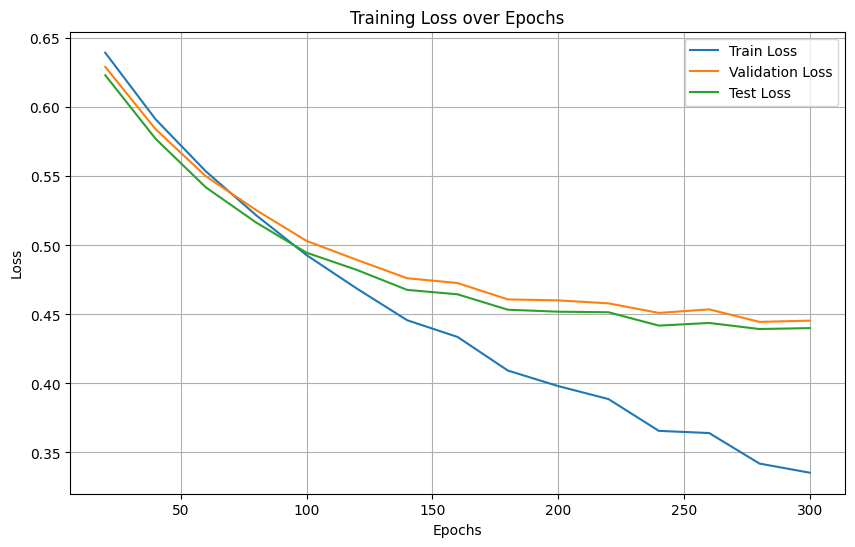

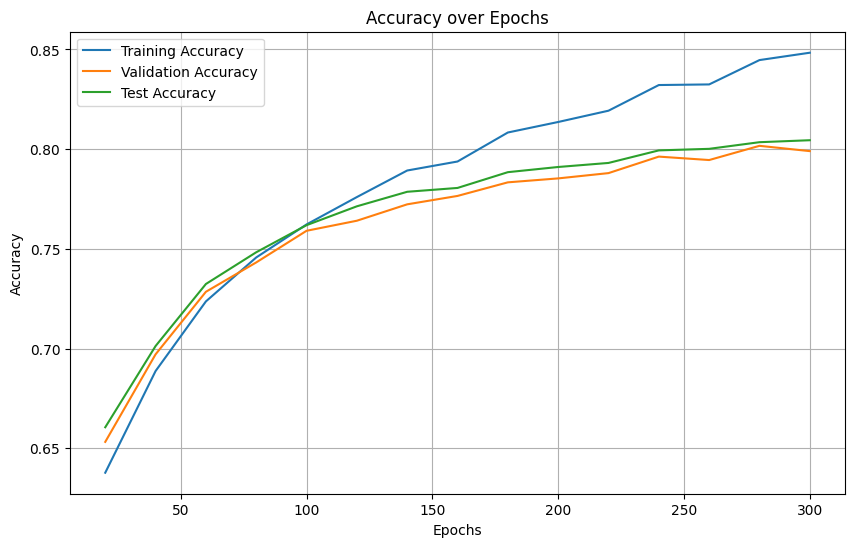

In [23]:
import matplotlib.pyplot as plt

plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [24]:
evaluate_baseline_model(model, test_data, device='cuda')

{'Accuracy': 0.8044948577880859,
 'AUC': 0.8819493254857287,
 'Average Precision (AP)': 0.8936641556336468,
 'Precision': 0.8103612670833775,
 'Recall': 0.7953623791203078,
 'F1-Score': 0.802791771620487,
 'Mean Reciprocal Rank (MRR)': 0.0009981758737129306}

### Homogenous

In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        # Initiralize layer module & GCN Conv layers
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels=-1, out_channels=hidden_channels))
        self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        # Pass through each layer, ReLu, Dropout
        for i in range(len((self.convs))):
            x = self.convs[i](x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x

class GATEncoder(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=4):
        super(GATEncoder, self).__init__()
        # Initialize layer module & GAT Conv layers
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(in_channels=-1, out_channels=hidden_channels, heads=heads))
        self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        self.convs.append(GATConv(hidden_channels * heads, out_channels, heads=heads))

    def forward(self, x, edge_index):
        # Pass through each layer, ReLu, Dropout
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x

class SageEncoder(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.5, aggr='mean'):
        super(SageEncoder, self).__init__()
        # Initialize module and SAGEConv layers
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels=-1, out_channels=hidden_channels, aggr=aggr))
        self.convs.append(SAGEConv(hidden_channels, hidden_channels, aggr=aggr))
        self.convs.append(SAGEConv(hidden_channels, out_channels, aggr=aggr))
        self.dropout=dropout

    def forward(self, x, edge_index):
        # Pass through each conv, ReLu, Dropout
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

class LinkDecoder(nn.Module):
    # Compute dot product
    def forward(self, edge, edge_index):
        src, dst = edge_index
        score = (edge[src] * edge[dst]).sum(dim=-1) # Dot product)
        return score

### GCN

In [ ]:
# model initialization
encoder = GCNEncoder(hidden_channels=128, out_channels=64)
predictor = LinkDecoder()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()),lr=0.01)

# training loop
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

# Iterate epochs
epoch_count = 300
epochs = range(1, epoch_count + 1)
for epoch in epochs:

    # Set models to train mode
    encoder.train()
    predictor.train()

    # Reset gradient
    optimizer.zero_grad()

    # Extract node features and edges from the training data
    x = G_homo_train.x
    edge_index = G_homo_train.edge_index

    # Encode the node embeddings
    embeds = encoder(x, edge_index)

    # Get positive and negative examples
    pos_edge_index = G_homo_train.pos_edge_label_index
    neg_edge_index = G_homo_train.neg_edge_label_index

    preds, labels = get_preds_labels(embeds, pos_edge_index, neg_edge_index, predictor)
    # Use binary cross entropy with logits
    loss = F.binary_cross_entropy_with_logits(preds, labels)
    loss.backward()
    optimizer.step()


    if epoch % 20 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            # Load Val Data
            data = G_homo_val

            # Set models to eval mode (i.e. for dropout)
            encoder.eval()
            predictor.eval()

            # Get outputs
            embeds = encoder(data.x, data.edge_index)

            # Compute predictions
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5

            # Calculate accuracy, loss
            val_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            correct = preds_truth.eq(labels.bool()).sum().item()
            val_acc = correct / labels.size(0)

            # Repeat for Test
            data = G_homo_test
            encoder.eval()
            predictor.eval()
            embeds = encoder(data.x, data.edge_index)
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5
            test_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            correct = preds_truth.eq(labels.bool()).sum().item()
            test_acc = correct / labels.size(0)


            # Repeat for Train
            data = G_homo_train
            encoder.eval()
            predictor.eval()
            embeds = encoder(data.x, data.edge_index)
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5
            correct = preds_truth.eq(labels.bool()).sum().item()
            train_acc = correct / labels.size(0)


        # Save statistics
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")


KeyboardInterrupt: 

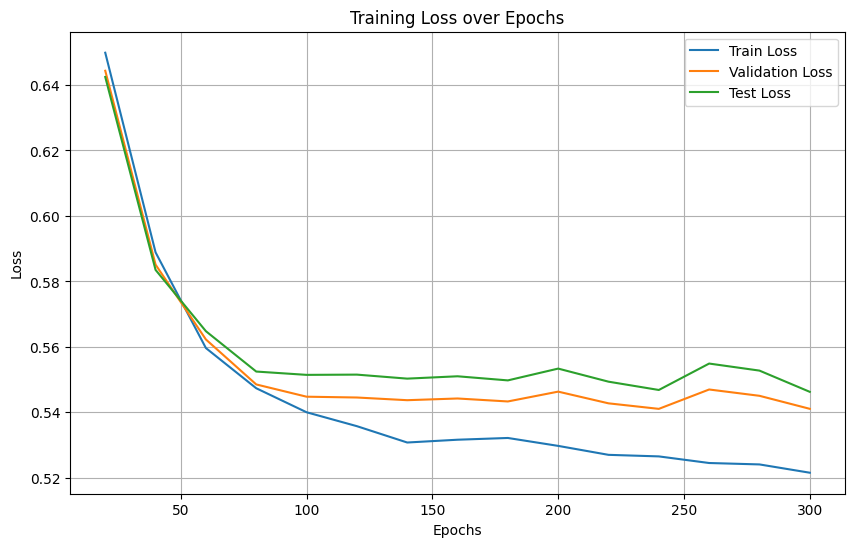

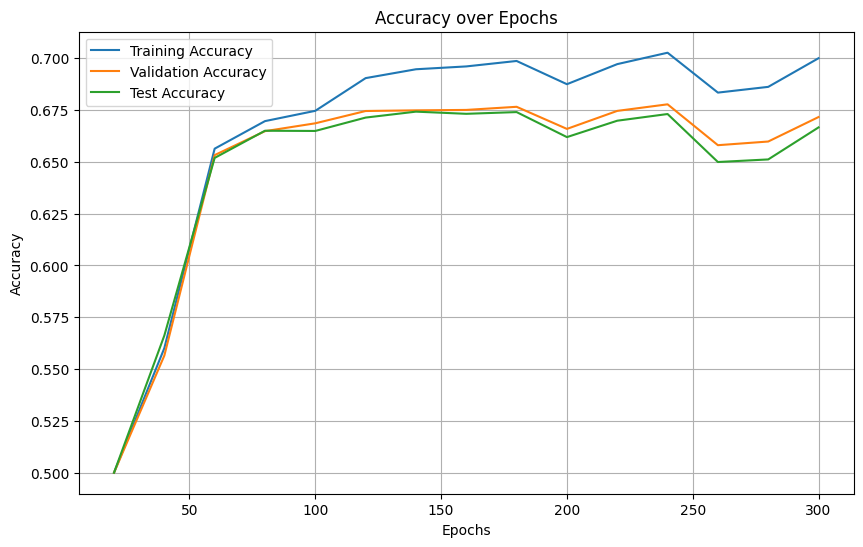

In [ ]:
import matplotlib.pyplot as plt

plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
evaluate_model(encoder, predictor, G_homo_test, is_hetero=False, device='cuda')

{'Accuracy': 0.6665799617767334,
 'AUC': 0.8430336673435687,
 'Average Precision (AP)': 0.8757269330598753,
 'Precision': 0.6150805060379528,
 'Recall': 0.890333992300489,
 'F1-Score': 0.7275432555371338,
 'Mean Reciprocal Rank (MRR)': 0.0009960358984044716}

### GAT

In [ ]:
encoder = GATEncoder(hidden_channels=128, out_channels=64, heads=4) # model initialization
predictor = LinkDecoder()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()),lr=0.0001)

# training loop
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

# Iterate epochs
epoch_count = 300
epochs = range(1, epoch_count + 1)
for epoch in epochs:

    # Set models to train mode
    encoder.train()
    predictor.train()

    # Reset gradient
    optimizer.zero_grad()

    # Extract node features and edges from the training data
    x = G_homo_train.x
    edge_index = G_homo_train.edge_index

    # Encode the node embeddings
    embeds = encoder(x, edge_index)

    # Get positive and negative examples
    pos_edge_index = G_homo_train.pos_edge_label_index
    neg_edge_index = G_homo_train.neg_edge_label_index

    preds, labels = get_preds_labels(embeds, pos_edge_index, neg_edge_index, predictor)
    # Use binary cross entropy with logits
    loss = F.binary_cross_entropy_with_logits(preds, labels)
    loss.backward()
    optimizer.step()


    if epoch % 20 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            # Load Val Data
            data = G_homo_val

            # Set models to eval mode (i.e. for dropout)
            encoder.eval()
            predictor.eval()

            # Get outputs
            embeds = encoder(data.x, data.edge_index)

            # Compute predictions
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5

            # Calculate accuracy, loss
            val_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            correct = preds_truth.eq(labels.bool()).sum().item()
            val_acc = correct / labels.size(0)

            # Repeat for Test
            data = G_homo_test
            encoder.eval()
            predictor.eval()
            embeds = encoder(data.x, data.edge_index)
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5
            test_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            correct = preds_truth.eq(labels.bool()).sum().item()
            test_acc = correct / labels.size(0)


            # Repeat for Train
            data = G_homo_train
            encoder.eval()
            predictor.eval()
            embeds = encoder(data.x, data.edge_index)
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5
            correct = preds_truth.eq(labels.bool()).sum().item()
            train_acc = correct / labels.size(0)


        # Save statistics

        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")



Epoch: 020, Loss: 0.6924, Val: 0.5000
Epoch: 040, Loss: 0.6897, Val: 0.5000
Epoch: 060, Loss: 0.6828, Val: 0.5044
Epoch: 080, Loss: 0.6667, Val: 0.5294
Epoch: 100, Loss: 0.6407, Val: 0.6275
Epoch: 120, Loss: 0.6163, Val: 0.6544
Epoch: 140, Loss: 0.6068, Val: 0.6587
Epoch: 160, Loss: 0.6021, Val: 0.6645
Epoch: 180, Loss: 0.5963, Val: 0.6602
Epoch: 200, Loss: 0.5932, Val: 0.6602
Epoch: 220, Loss: 0.5877, Val: 0.6582
Epoch: 240, Loss: 0.5829, Val: 0.6582
Epoch: 260, Loss: 0.5805, Val: 0.6585
Epoch: 280, Loss: 0.5776, Val: 0.6521
Epoch: 300, Loss: 0.5727, Val: 0.6573


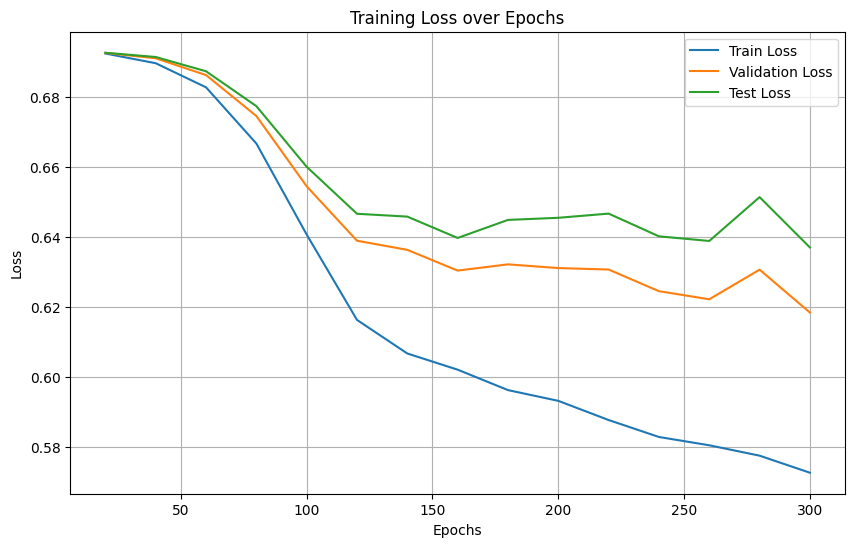

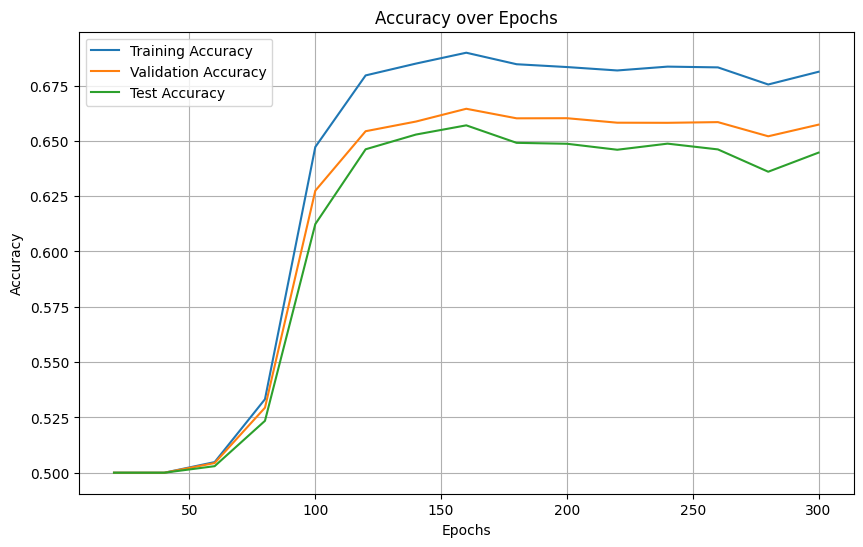

In [ ]:
import matplotlib.pyplot as plt

plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
evaluate_model(encoder, predictor, G_homo_test, is_hetero=False, device='cuda')

{'Accuracy': 0.644677996635437,
 'AUC': 0.7990892920108829,
 'Average Precision (AP)': 0.7876108054535013,
 'Precision': 0.5925211258234081,
 'Recall': 0.926542503381542,
 'F1-Score': 0.7228084415584416,
 'Mean Reciprocal Rank (MRR)': 0.000627642286818497}

### GraphSAGE

In [ ]:
encoder = SageEncoder(hidden_channels=64, out_channels=64, dropout=0.2, aggr='mean') # model initialization
predictor = LinkDecoder()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()),lr=0.01)

# training loop
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

# Iterate epochs
epoch_count = 400
epochs = range(1, epoch_count + 1)
for epoch in epochs:

    # Set models to train mode
    encoder.train()
    predictor.train()

    # Reset gradient
    optimizer.zero_grad()

    # Extract node features and edges from the training data
    x = G_homo_train.x
    edge_index = G_homo_train.edge_index

    # Encode the node embeddings
    embeds = encoder(x, edge_index)

    # Get positive and negative examples
    pos_edge_index = G_homo_train.pos_edge_label_index
    neg_edge_index = G_homo_train.neg_edge_label_index

    preds, labels = get_preds_labels(embeds, pos_edge_index, neg_edge_index, predictor)
    # Use binary cross entropy with logits
    loss = F.binary_cross_entropy_with_logits(preds, labels)
    loss.backward()
    optimizer.step()


    if epoch % 20 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            # Load Val Data
            data = G_homo_val

            # Set models to eval mode (i.e. for dropout)
            encoder.eval()
            predictor.eval()

            # Get outputs
            embeds = encoder(data.x, data.edge_index)

            # Compute predictions
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5

            # Calculate accuracy, loss
            val_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            correct = preds_truth.eq(labels.bool()).sum().item()
            val_acc = correct / labels.size(0)

            # Repeat for Test
            data = G_homo_test
            encoder.eval()
            predictor.eval()
            embeds = encoder(data.x, data.edge_index)
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5
            test_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            correct = preds_truth.eq(labels.bool()).sum().item()
            test_acc = correct / labels.size(0)


            # Repeat for Train
            data = G_homo_train
            encoder.eval()
            predictor.eval()
            embeds = encoder(data.x, data.edge_index)
            preds, labels = get_preds_labels(embeds, data.pos_edge_label_index, data.neg_edge_label_index, predictor)
            preds_truth = torch.sigmoid(preds) > 0.5
            correct = preds_truth.eq(labels.bool()).sum().item()
            train_acc = correct / labels.size(0)

            # Save statistics
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")



Epoch: 020, Loss: 0.6791, Val: 0.5678
Epoch: 040, Loss: 0.6663, Val: 0.5787
Epoch: 060, Loss: 0.6299, Val: 0.6220
Epoch: 080, Loss: 0.5933, Val: 0.6598
Epoch: 100, Loss: 0.5747, Val: 0.6566
Epoch: 120, Loss: 0.5665, Val: 0.6652
Epoch: 140, Loss: 0.5600, Val: 0.6715
Epoch: 160, Loss: 0.5557, Val: 0.6726
Epoch: 180, Loss: 0.5519, Val: 0.6745
Epoch: 200, Loss: 0.5505, Val: 0.6750
Epoch: 220, Loss: 0.5501, Val: 0.6769
Epoch: 240, Loss: 0.5448, Val: 0.6802
Epoch: 260, Loss: 0.5442, Val: 0.6788
Epoch: 280, Loss: 0.5436, Val: 0.6784
Epoch: 300, Loss: 0.5372, Val: 0.6826
Epoch: 320, Loss: 0.5350, Val: 0.6842
Epoch: 340, Loss: 0.5321, Val: 0.6855
Epoch: 360, Loss: 0.5341, Val: 0.6909
Epoch: 380, Loss: 0.5298, Val: 0.6846
Epoch: 400, Loss: 0.5302, Val: 0.6863


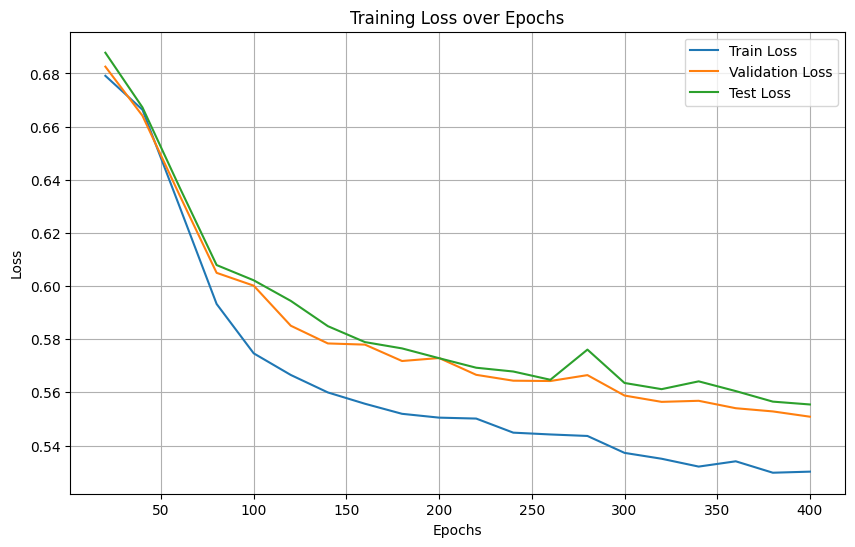

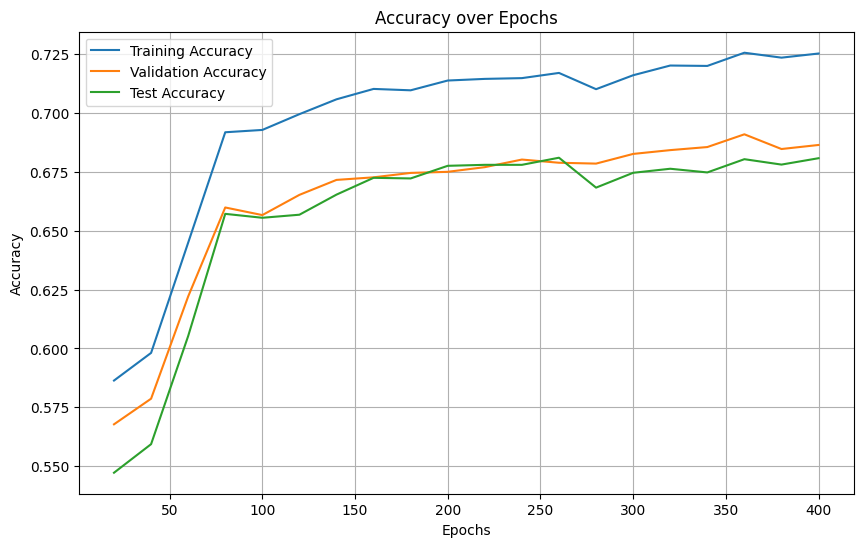

In [ ]:

plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
evaluate_model(encoder, predictor, G_homo_test, is_hetero=False, device='cuda')

{'Accuracy': 0.680730402469635,
 'AUC': 0.8395464486212123,
 'Average Precision (AP)': 0.857178082987469,
 'Precision': 0.6260705472492379,
 'Recall': 0.8975132660493185,
 'F1-Score': 0.7376116978066612,
 'Mean Reciprocal Rank (MRR)': 0.0009769710492560934}

### Heterogenous Unweighted

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GraphConv

class LinkDecoderHetero(nn.Module):
    def forward(self, src_e, dst_e, edge_index):
        # Compute Dot Product
        src, dst = edge_index
        score = (src_e[src] * dst_e[dst]).sum(dim=-1)
        return score


class GATEncoderHetero(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=4):
        super(GATEncoderHetero, self).__init__()
        # Initialize layer module & GATConv layers
        self.convs = nn.ModuleList()
        self.convs.append(GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False))
        self.convs.append(GATConv((hidden_channels * heads, hidden_channels * heads), hidden_channels, heads=heads, add_self_loops=False))
        self.convs.append(GATConv((hidden_channels * heads, hidden_channels * heads), out_channels, heads=heads, concat=False, add_self_loops=False))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            # Apply non-linearity and dropout
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x

class GCNEncoderHetero(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.5):
        super(GCNEncoderHetero, self).__init__()
        # Initialize layer module & GraphConv layers
        self.convs = nn.ModuleList()
        self.convs.append(GraphConv(in_channels=(-1,-1), out_channels=hidden_channels))
        self.convs.append(GraphConv(hidden_channels, hidden_channels))
        self.convs.append(GraphConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i in range(len((self.convs))):
            x = self.convs[i](x, edge_index)
            # Apply non-linearity and dropout
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x


#### GCN

In [ ]:
# Establish Encoder (Convert to Hetero) and Decoder
encoder = GCNEncoderHetero(hidden_channels=128, out_channels=64, dropout=0.2)
encoder = to_hetero(encoder, (G_hetero_train.node_types, G_hetero_train.edge_types))
predictor = LinkDecoderHetero()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()),lr=0.01)

# Initialize Train-time tracking
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

# Specify Train Duration
epoch_count = 200
epochs = range(1, epoch_count + 1)

# Specify target edge
target_edge_type = ('user', 'interacts_with', 'user')

for epoch in epochs:
    encoder.train()
    predictor.train()
    optimizer.zero_grad()

    # Training step
    data = G_hetero_train
    node_embeds = encoder(data.x_dict, data.edge_index_dict)

    pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
    neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

    preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
    loss = F.binary_cross_entropy_with_logits(preds, labels)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            # Validation Assess
            data = G_hetero_val
            node_embeds = encoder(data.x_dict, data.edge_index_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            val_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            val_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Test Assess
            data = G_hetero_test
            node_embeds = encoder(data.x_dict, data.edge_index_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            test_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            test_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Train Assess
            data = G_hetero_train
            node_embeds = encoder(data.x_dict, data.edge_index_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            pred = torch.sigmoid(preds) > 0.5
            train_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)


            # Save statistics
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Epoch: 020, Loss: 74626.3281, Val: 0.5749
Epoch: 040, Loss: 8920.9580, Val: 0.6016
Epoch: 060, Loss: 1822.9443, Val: 0.6024
Epoch: 080, Loss: 709.6978, Val: 0.6185
Epoch: 100, Loss: 310.2733, Val: 0.6062
Epoch: 120, Loss: 313.8847, Val: 0.6207
Epoch: 140, Loss: 163.9259, Val: 0.6034
Epoch: 160, Loss: 108.0972, Val: 0.6032
Epoch: 180, Loss: 79.9854, Val: 0.5885
Epoch: 200, Loss: 59.0512, Val: 0.6093


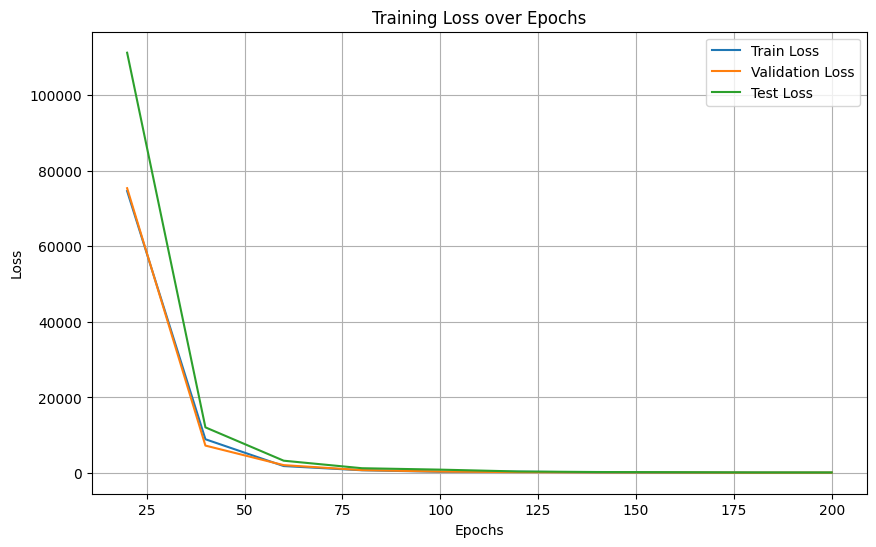

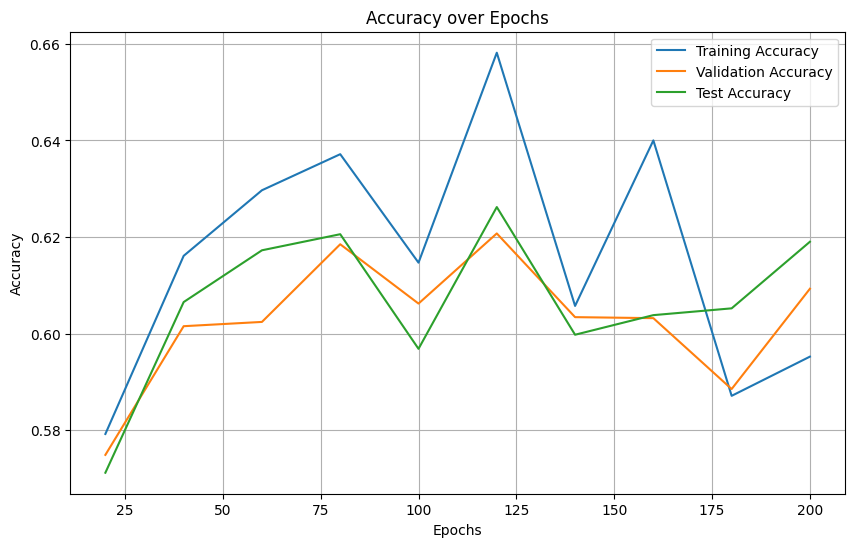

In [ ]:
plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
evaluate_model(encoder, predictor, G_hetero_test, is_hetero=True, device='cuda')

{'Accuracy': 0.5894287824630737,
 'AUC': 0.6796397444613789,
 'Average Precision (AP)': 0.6569872428825969,
 'Precision': 0.5625500327487083,
 'Recall': 0.8042867547601706,
 'F1-Score': 0.6620417951353204,
 'Mean Reciprocal Rank (MRR)': 0.0009513609170251719}

In [ ]:
# Establish Encoder (Convert to Hetero) and Decoder
encoder = GATEncoderHetero(hidden_channels=128, out_channels=64, heads=4)
encoder = to_hetero(encoder, (G_hetero_train.node_types, G_hetero_train.edge_types))
predictor = LinkDecoderHetero()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()),lr=0.0005)

# Initialize Train-time tracking
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

# Specify Train Duration
epoch_count = 300
epochs = range(1, epoch_count + 1)

# Specify target edge
target_edge_type = ('user', 'interacts_with', 'user')

for epoch in epochs:
    encoder.train()
    predictor.train()
    optimizer.zero_grad()

    # Training step
    data = G_hetero_train
    node_embeds = encoder(data.x_dict, data.edge_index_dict)

    pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
    neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

    preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
    loss = F.binary_cross_entropy_with_logits(preds, labels)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            # Validation Assess
            data = G_hetero_val
            node_embeds = encoder(data.x_dict, data.edge_index_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            val_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            val_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Test Assess
            data = G_hetero_test
            node_embeds = encoder(data.x_dict, data.edge_index_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            test_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            test_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Train Assess
            data = G_hetero_train
            node_embeds = encoder(data.x_dict, data.edge_index_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            pred = torch.sigmoid(preds) > 0.5
            train_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)


            # Save statistics
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Epoch: 020, Loss: 0.6833, Val: 0.5638
Epoch: 040, Loss: 0.6626, Val: 0.5730
Epoch: 060, Loss: 0.6564, Val: 0.5835
Epoch: 080, Loss: 0.6294, Val: 0.5940
Epoch: 100, Loss: 0.6088, Val: 0.6465
Epoch: 120, Loss: 0.5943, Val: 0.6750
Epoch: 140, Loss: 0.5813, Val: 0.6662
Epoch: 160, Loss: 0.5840, Val: 0.6798
Epoch: 180, Loss: 0.5788, Val: 0.6760
Epoch: 200, Loss: 0.5719, Val: 0.6797
Epoch: 220, Loss: 0.5779, Val: 0.6730
Epoch: 240, Loss: 0.5693, Val: 0.6737
Epoch: 260, Loss: 0.5688, Val: 0.6804
Epoch: 280, Loss: 0.5641, Val: 0.6791
Epoch: 300, Loss: 0.5638, Val: 0.6789


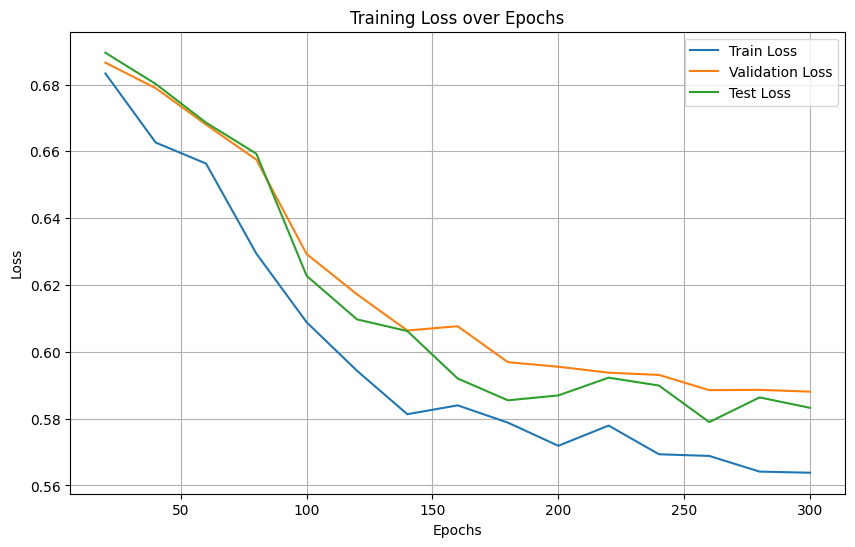

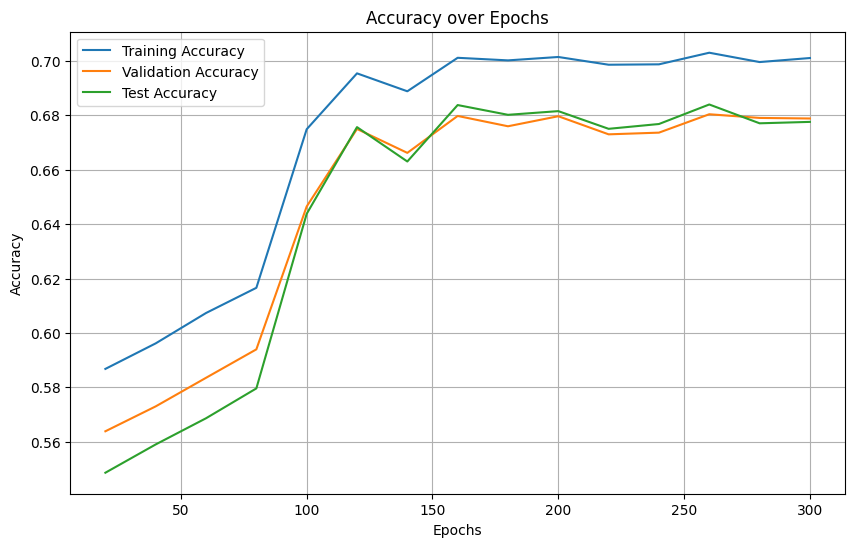

In [ ]:
plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
evaluate_model(encoder, predictor, G_hetero_test, is_hetero=True, device='cuda')

{'Accuracy': 0.6793257594108582,
 'AUC': 0.822447640431601,
 'Average Precision (AP)': 0.8192386380629224,
 'Precision': 0.6229929351316634,
 'Recall': 0.9083342003953803,
 'F1-Score': 0.739078902810701,
 'Mean Reciprocal Rank (MRR)': 0.0008828020156229887}

### Heterogeneous Weighted

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GraphConv, to_hetero

class GATEncoderHeteroWeighted(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=4):
        super(GATEncoderHeteroWeighted, self).__init__()
        # Initiralize Layer Module & GATConv layers
        self.convs = nn.ModuleList()
        self.convs.append(GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False))
        self.convs.append(GATConv((hidden_channels * heads, hidden_channels * heads), hidden_channels, heads=heads, add_self_loops=False))
        self.convs.append(GATConv((hidden_channels * heads, hidden_channels * heads), out_channels, heads=heads, concat=False, add_self_loops=False))

    def forward(self, x, edge_index, edge_weight_dict=None):
        for i, conv in enumerate(self.convs):
            # Check for edge weight, apply
            if edge_weight_dict is not None:
                x = conv(x, edge_index, edge_attr=edge_weight_dict)
            else:
                x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x

class GCNEncoderHeteroWeighted(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout):
        # Initiralize Layer module, GraphConv layers
        super(GCNEncoderHeteroWeighted, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GraphConv(-1, hidden_channels))
        self.convs.append(GraphConv(hidden_channels, hidden_channels))
        self.convs.append(GraphConv(hidden_channels, out_channels))
        self.dropout=dropout

    def forward(self, x, edge_index, edge_weight_dict=None):
        for i, conv in enumerate(self.convs):
            # Check for edge weight, apply
            if edge_weight_dict is not None:
                x = conv(x, edge_index, edge_weight=edge_weight_dict)
            else:
                x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

### GCN

In [ ]:
# Establish Encoder (Convert to Hetero) and Decoder
encoder = GCNEncoderHeteroWeighted(hidden_channels=128, out_channels=64, dropout=0.5)
encoder = to_hetero(encoder, (G_hetero_weighted_train.node_types, G_hetero_weighted_train.edge_types))
predictor = LinkDecoderHetero()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()),lr=0.000005)

# Initialize Train-time tracking
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

# Specify Train Duration
epoch_count = 1000
epochs = range(1, epoch_count + 1)

# Specify target edge
target_edge_type = ('user', 'interacts_with', 'user')

for epoch in epochs:
    encoder.train()
    predictor.train()
    optimizer.zero_grad()

    # Training step
    data = G_hetero_weighted_train
    node_embeds = encoder(data.x_dict, data.edge_index_dict)

    pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
    neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

    preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
    loss = F.binary_cross_entropy_with_logits(preds, labels)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            # Validation Assess
            data = G_hetero_weighted_val
            node_embeds = encoder(data.x_dict, data.edge_index_dict, data.edge_weight_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            val_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            val_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Test Assess
            data = G_hetero_weighted_test
            node_embeds = encoder(data.x_dict, data.edge_index_dict, data.edge_weight_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            test_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            test_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Train Assess
            data = G_hetero_weighted_train
            node_embeds = encoder(data.x_dict, data.edge_index_dict, data.edge_weight_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            pred = torch.sigmoid(preds) > 0.5
            train_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)


            # Save statistics
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Epoch: 020, Loss: 240352.0000, Val: 0.5037
Epoch: 040, Loss: 140923.3438, Val: 0.5045
Epoch: 060, Loss: 102271.2031, Val: 0.5058
Epoch: 080, Loss: 74426.1641, Val: 0.5128
Epoch: 100, Loss: 62101.9922, Val: 0.5081
Epoch: 120, Loss: 42905.2578, Val: 0.5110
Epoch: 140, Loss: 35993.1250, Val: 0.5128
Epoch: 160, Loss: 27750.1367, Val: 0.5133
Epoch: 180, Loss: 24522.5605, Val: 0.5145
Epoch: 200, Loss: 19647.8398, Val: 0.5140
Epoch: 220, Loss: 17355.1094, Val: 0.5144
Epoch: 240, Loss: 15183.4834, Val: 0.5104
Epoch: 260, Loss: 13776.8945, Val: 0.5158
Epoch: 280, Loss: 10662.4609, Val: 0.5141
Epoch: 300, Loss: 10674.2197, Val: 0.5153
Epoch: 320, Loss: 8442.5186, Val: 0.5178
Epoch: 340, Loss: 8530.9775, Val: 0.5047
Epoch: 360, Loss: 6770.1958, Val: 0.5146
Epoch: 380, Loss: 6277.2744, Val: 0.5114
Epoch: 400, Loss: 5491.3916, Val: 0.5135
Epoch: 420, Loss: 5507.4541, Val: 0.5124
Epoch: 440, Loss: 5167.5054, Val: 0.5117
Epoch: 460, Loss: 4267.1265, Val: 0.5162
Epoch: 480, Loss: 3868.1292, Val: 0.513

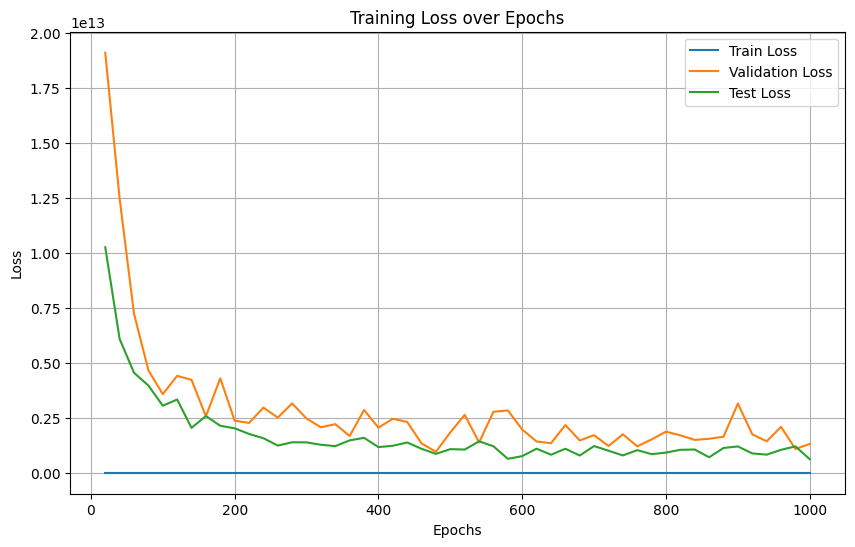

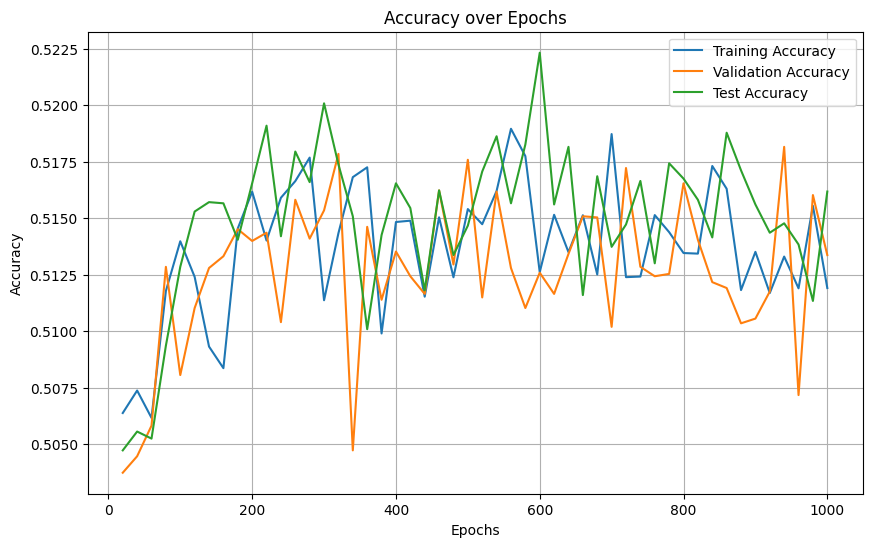

In [ ]:
plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
evaluate_model(encoder, predictor, G_hetero_weighted_test, is_hetero=True, device='cuda')

{'Accuracy': 0.6036832928657532,
 'AUC': 0.6140038908829721,
 'Average Precision (AP)': 0.5681698631383869,
 'Precision': 0.5644025075938732,
 'Recall': 0.908646342732286,
 'F1-Score': 0.6963004305533408,
 'Mean Reciprocal Rank (MRR)': 0.00012939699146094215}

### GAT

In [ ]:
# Establish Encoder (Convert to Hetero) and Decoder
encoder = GATEncoderHeteroWeighted(hidden_channels=128, out_channels=64, heads=4)
encoder = to_hetero(encoder, (G_hetero_weighted_train.node_types, G_hetero_weighted_train.edge_types))
predictor = LinkDecoderHetero()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(predictor.parameters()),lr=0.0005)

# Initialize Train-time tracking
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

# Specify Train Duration
epoch_count = 300
epochs = range(1, epoch_count + 1)

# Specify target edge
target_edge_type = ('user', 'interacts_with', 'user')

for epoch in epochs:
    encoder.train()
    predictor.train()
    optimizer.zero_grad()

    # Training step
    data = G_hetero_weighted_train
    node_embeds = encoder(data.x_dict, data.edge_index_dict)

    pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
    neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

    preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
    loss = F.binary_cross_entropy_with_logits(preds, labels)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_losses.append(loss.item())
        with torch.no_grad():
            # Validation Assess
            data = G_hetero_weighted_val
            node_embeds = encoder(data.x_dict, data.edge_index_dict, data.edge_weight_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            val_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            val_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Test Assess
            data = G_hetero_weighted_test
            node_embeds = encoder(data.x_dict, data.edge_index_dict, data.edge_weight_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            test_loss = F.binary_cross_entropy_with_logits(preds, labels).item()
            pred = torch.sigmoid(preds) > 0.5
            test_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)

            # Train Assess
            data = G_hetero_weighted_train
            node_embeds = encoder(data.x_dict, data.edge_index_dict, data.edge_weight_dict)
            pos_edge_index = data.pos_edge_label_index_dict[target_edge_type]
            neg_edge_index = data.neg_edge_label_index_dict[target_edge_type]

            preds, labels = get_preds_labels_hetero(node_embeds, pos_edge_index, neg_edge_index, target_edge_type[0], target_edge_type[2], predictor)
            pred = torch.sigmoid(preds) > 0.5
            train_acc = pred.eq(labels.bool()).sum().item() / labels.size(0)


            # Save statistics
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Epoch: 020, Loss: 0.6819, Val: 0.5661
Epoch: 040, Loss: 0.6612, Val: 0.5832
Epoch: 060, Loss: 0.6523, Val: 0.5796
Epoch: 080, Loss: 0.6381, Val: 0.6095
Epoch: 100, Loss: 0.6094, Val: 0.6471
Epoch: 120, Loss: 0.5907, Val: 0.6723
Epoch: 140, Loss: 0.5840, Val: 0.6609
Epoch: 160, Loss: 0.5737, Val: 0.6741
Epoch: 180, Loss: 0.5731, Val: 0.6785
Epoch: 200, Loss: 0.5683, Val: 0.6772
Epoch: 220, Loss: 0.5653, Val: 0.6811
Epoch: 240, Loss: 0.5647, Val: 0.6804
Epoch: 260, Loss: 0.5599, Val: 0.6772
Epoch: 280, Loss: 0.5599, Val: 0.6791
Epoch: 300, Loss: 0.5569, Val: 0.6815


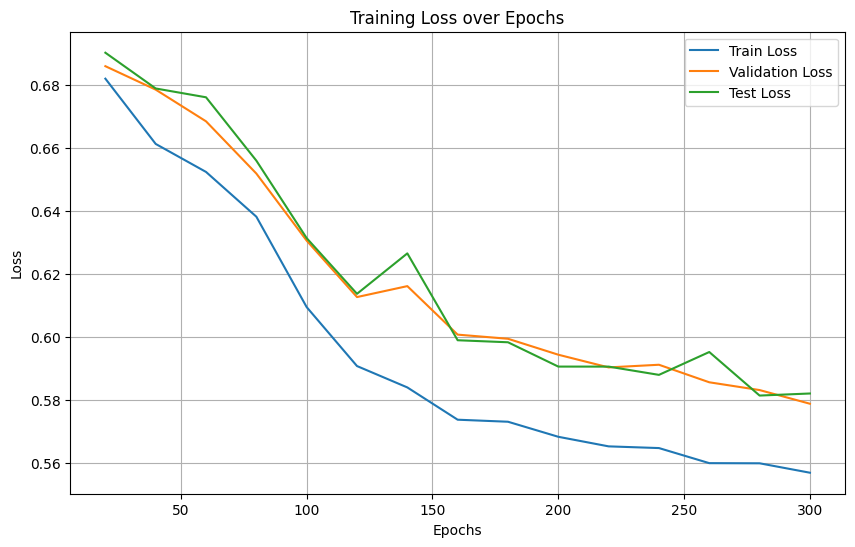

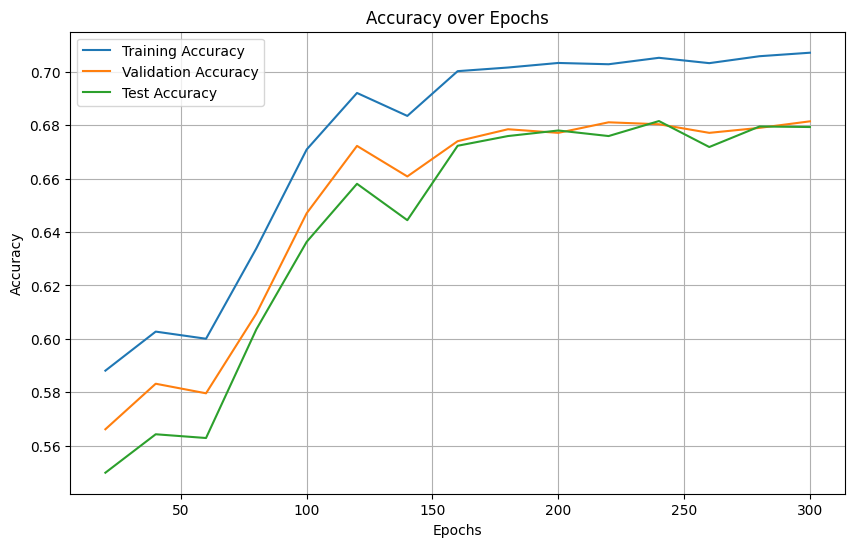

In [ ]:
plot_points = list([epoch*20 for epoch in range(1, len(train_losses) + 1)])
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_losses, label="Train Loss")
plt.plot(plot_points, val_losses, label="Validation Loss")
plt.plot(plot_points, test_losses, label="Test Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot validation and training accuracies
plt.figure(figsize=(10, 6))
plt.plot(plot_points, train_accs, label="Training Accuracy")
plt.plot(plot_points, val_accs, label="Validation Accuracy")
plt.plot(plot_points, test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
evaluate_model(encoder, predictor, G_hetero_weighted_test, is_hetero=True, device='cuda')

{'Accuracy': 0.6793257594108582,
 'AUC': 0.8162841419145668,
 'Average Precision (AP)': 0.8147772782752725,
 'Precision': 0.6242162162162163,
 'Recall': 0.9011549266465508,
 'F1-Score': 0.7375457719492463,
 'Mean Reciprocal Rank (MRR)': 0.0008517634096768014}